# Model Identification Notebook

In this notebook we will:
- visualize the recorded RSSI reading.
- divide the data into 80% 20%.
- get the RSSI to distance model based on the 80% of the data
- test our model and visualize the errors on the other remaining 20% of data

In [1]:
import pandas as pd

# import the data 
csv_file = '../data/1/FF-FF-30-02-3E-5C.csv'
df = pd.read_csv(csv_file)

df.head()

,distance,rssi
0,1,-39
1,1,-39
2,1,-39
3,1,-45
4,1,-53


In [15]:
# we have 50 readings for each distance
# we need to separate training and testing data for each distance

training_data = pd.DataFrame(
  columns=['distance','rssi']
)
testing_data = pd.DataFrame(
  columns=['distance','rssi']
)

unique_distances = df['distance'].unique()

for distance in df['distance'].unique():
    df_distance = df[df['distance'] == distance]
    df_distance = df_distance.sample(frac=1).reset_index(drop=True)
    # add column counter to keep track of the order of the readings
    df_distance['counter'] = df_distance.index
    training_data = pd.concat([training_data,df_distance[:40]])
    testing_data = pd.concat([testing_data,df_distance[40:]])

# training_data = training_data.reset_index()
# testing_data = testing_data.reset_index()

print("Number of unique distances: ", len(training_data['distance'].unique()))
print("Number of training readings for each distance: ", len(training_data['distance'])/len(training_data['distance'].unique()))
print("Number of testing readings for each distance: ", len(testing_data['distance'])/len(testing_data['distance'].unique()))

# print(training_data)

Number of unique distances:  28
Number of training readings for each distance:  40.0
Number of testing readings for each distance:  10.0


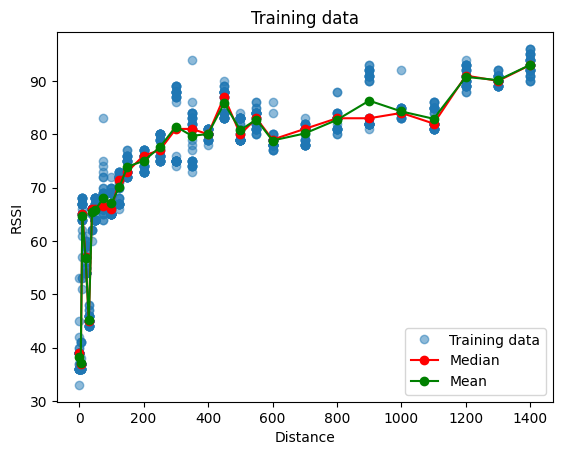

In [16]:
# visualize the data
# plot RSSI vs distance
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

median_by_distance = training_data.groupby('distance').median()['rssi']
mean_by_distance = training_data.groupby('distance').mean()['rssi']

unique_distances = np.array(training_data['distance'].unique(), dtype=np.float64)
median_by_distance = np.array(median_by_distance, dtype=np.float64)
mean_by_distance = np.array(mean_by_distance, dtype=np.float64)

plt.figure(
  # figsize=(10,10)
)
plt.plot(
  training_data['distance'],
  abs(training_data['rssi']),
  "o",
  alpha=0.5,
)
# plt median line for each distance
plt.plot(
  unique_distances,
  abs(median_by_distance),
  "-o",
  c='red',
)
# plt mean line for each distance
plt.plot(
  unique_distances,
  abs(mean_by_distance),
  "-o",
  c='green',
)

plt.title("Training data")

plt.xlabel("Distance")
plt.ylabel("RSSI")

plt.legend([
  "Training data",
  "Median",
  "Mean",
])


plt.show()


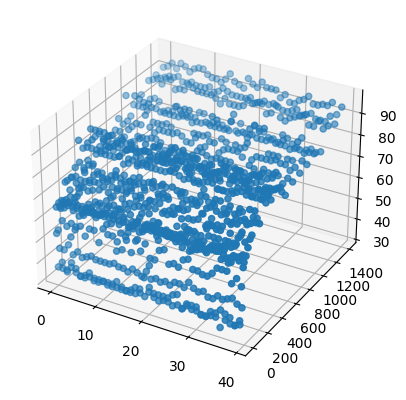

In [17]:
# plot 3d RSSI vs distance vs counter
%matplotlib inline
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

z = abs(training_data['rssi'])
y = training_data['distance']
x = training_data['counter']

ax.scatter(x, y, z, 'blue')

plt.show()

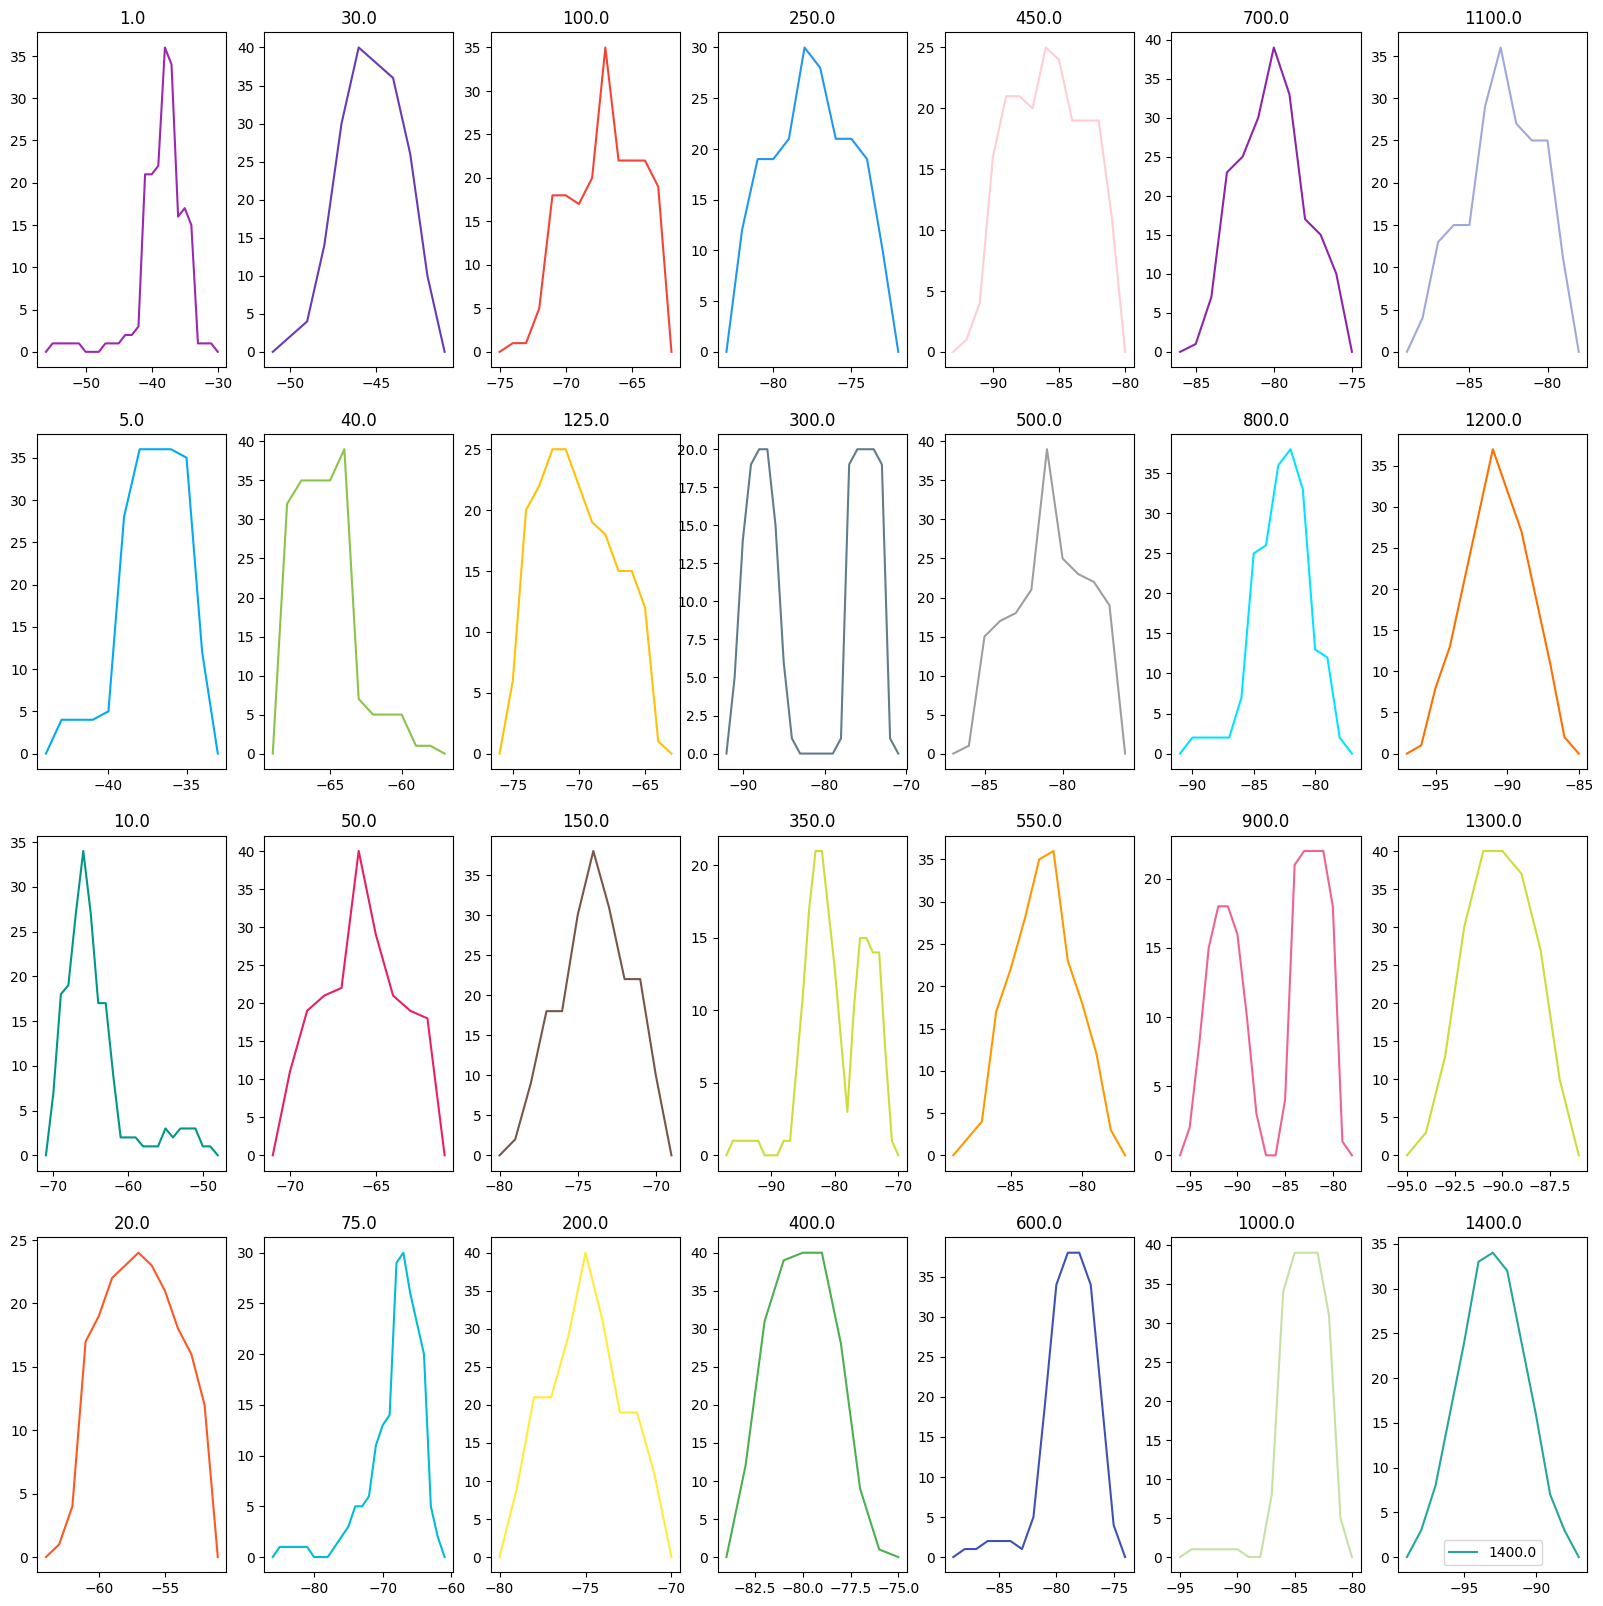

In [18]:
%matplotlib inline
# plot distribution for each distance in a single plot
colors = [ "#9c27b0", "#03a9f4", "#009688", "#ff5722", "#673ab7", "#8bc34a", "#e91e63", "#00bcd4", "#f44336", "#ffc107", "#795548", "#ffeb3b", "#2196f3", "#607d8b", "#cddc39", "#4caf50", "#ffcdd2", "#9e9e9e", "#ff9800", "#3f51b5", "#8e24aa", "#00e5ff", "#f06292", "#c5e1a5", "#9fa8da", "#ff6f00", "#cddc39", "#26a69a", ]

with open('model.txt', 'w') as f:
    f.write("distance,variance,standard_deviation,mean,median\n")

rssi_tolerance = 2

fig, axs = plt.subplots(4,7,figsize=(20,20))

index = -1
distributions = []
for color, distance in zip(colors, unique_distances):
    index += 1
    df_distance = training_data[training_data['distance'] == distance]
    minimum = df_distance['rssi'].min()
    maximum = df_distance['rssi'].max()
    
    distribution = []
    rssi_range = range(minimum-rssi_tolerance-1, maximum+rssi_tolerance+2)
    for i in rssi_range:
        distribution.append(len(df_distance[abs(df_distance['rssi']  - i)<= rssi_tolerance]))
        
    distributions.append(distribution)
        
    np_distribution = np.array(df_distance["rssi"])
    variance = np.var(np_distribution).round(2)
    standard_deviation = np.std(np_distribution).round(2)
    mean = np.mean(np_distribution).round(2)
    median = np.median(np_distribution).round(2)
    
    with open('model.txt', 'a') as f:
        f.write(f"{distance},{variance},{standard_deviation},{mean},{median}\n")
    
    x = index//4
    y = index%4
    axs[y][x].plot(rssi_range,distribution, color=color, label=distance)
    axs[y][x].set_title(distance)
    
plt.legend()
plt.show()



In [19]:
# get logarithmic model

a,b = np.polyfit(
    np.log(unique_distances),
    abs(mean_by_distance), 
    1
  )

b += 0
a += 0

a,b

(7.526798662966014, 34.61827185958462)

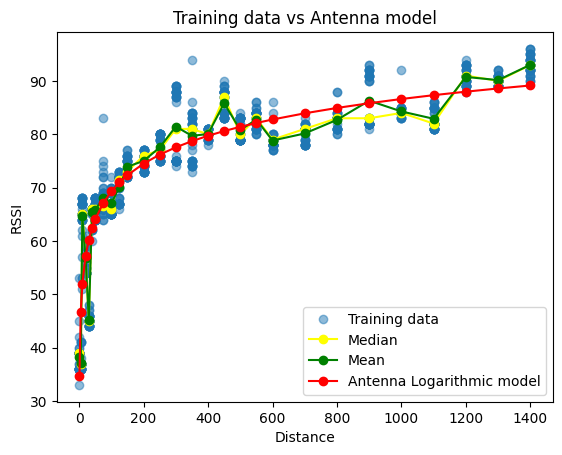

In [20]:
# plot previous plot with logarithmic model

plt.plot(
  training_data['distance'],
  abs(training_data['rssi']),
  "o",
  alpha=0.5,
)


# plt median line for each distance
plt.plot(
  unique_distances,
  abs(median_by_distance),
  "-o",
  c='yellow',
)
# plt mean line for each distance
plt.plot(
  unique_distances,
  abs(mean_by_distance),
  "-o",
  c='green',
)

plt.plot(
  unique_distances,
  [a*np.log(i)+b for i in unique_distances],
  "-o",
  c='red'
)

plt.title("Training data vs Antenna model")

plt.xlabel("Distance")
plt.ylabel("RSSI")

plt.legend([
  "Training data",
  "Median",
  "Mean",
  "Antenna Logarithmic model"
])

plt.show()

In [21]:
get_rssi = lambda distance: a*np.log(distance)+b
get_distance = lambda rssi: np.exp((rssi-b)/a)
# a2 = 8.417764109766877
# b2 =  66.98298983521134
# get_rssi_2 = lambda distance: a2*np.log(distance/100)+b2
# get_distance_2 = lambda rssi: np.exp((rssi-b2)/a2)

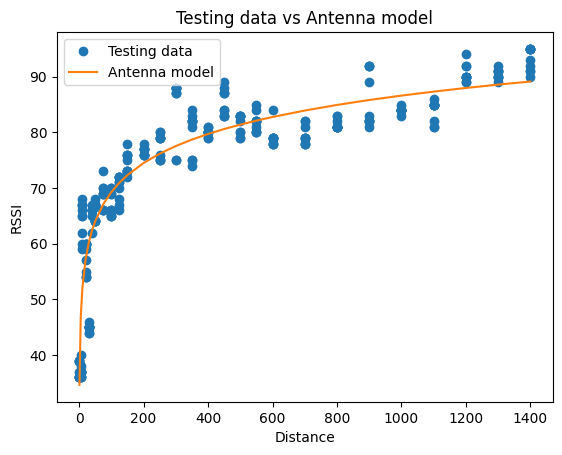

In [22]:
# plot testing data with logarithmic model
plt.plot(
  testing_data["distance"],
  abs(testing_data["rssi"]),
  "o"
)
plt.plot(
  testing_data["distance"],
  testing_data["distance"].apply(get_rssi),
)
# plt.plot(
#   testing_data["distance"],
#   testing_data["distance"].apply(get_rssi_2),
# )

plt.title("Testing data vs Antenna model")

plt.xlabel("Distance")
plt.ylabel("RSSI")

plt.legend(["Testing data", "Antenna model"])


plt.show()

Model accuracy: 77.5%


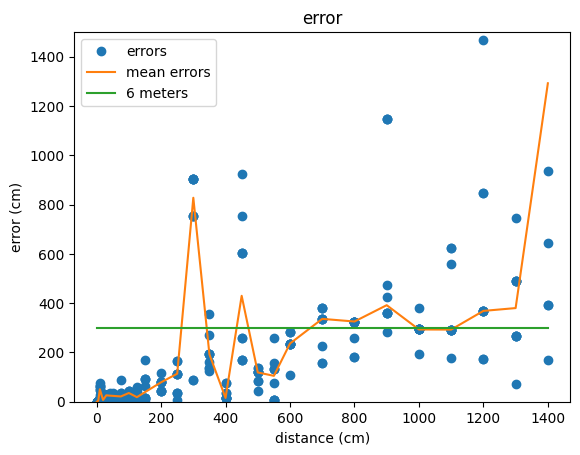

In [37]:
# plot errors

# testing_data = training_data.copy()

testing_data['rssi'] = abs(testing_data['rssi'])
testing_data['predicted_distance'] = testing_data['rssi'].apply(get_distance)
testing_data['error'] = abs(testing_data['distance'] - testing_data['predicted_distance']) #*100 / testing_data['distance']
testing_data['relative_error'] = testing_data['error'] * 100 / testing_data['distance']

error_lim = 3 * 100 # meters

model_accuracy = len(testing_data[testing_data['error'] <= error_lim])* 100 / len(testing_data)
print(f"Model accuracy: {model_accuracy}%")

plt.plot(
  testing_data["distance"],
  testing_data["error"],
  "o"
)

# smoth the plot
plt.plot(
  testing_data["distance"].unique(),
  testing_data.groupby("distance")["error"].median().rolling(1).mean(),
)

plt.plot(
  testing_data["distance"].unique(),
  np.ones(len(testing_data["distance"].unique()))*error_lim,
)

plt.title("error")

plt.ylim(0, 1500)

plt.xlabel("distance (cm)")
plt.ylabel("error (cm)")

plt.legend(["errors", "mean errors", "6 meters"])

plt.show()